## Training Model

### how can we predict multiple swell heights and directions? 

- each time stamp (every 30 minutes) has the dominant swell height. We want to predict this
- for a 1 day prediction. get all the data as late as one day ago, and this is a data point with many dimensions. Maybe grab a snapshot of each buoy from 
- encode this into a large vector. Use WvHT (waveheight), MWD (main swell direction in degrees), ans SwP as prediction. 
- using a neural network is a good solution, because the data is high dimensional and non linear

In [2]:
import torch
import pandas as pd
import sqlite3
import numpy as np
import functions

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt

In [39]:
conn = sqlite3.connect('db.db')
data = pd.read_sql_query("SELECT * from main", conn)
data = functions.buildnparray(functions.cleanData(data))

(1387, 76, 3)


### parameters and building data

In [62]:
sequence_length = 24 * 10  # length of sequence, 24 hours * 10 days
batch_size = 32      # Batch size for training
num_epochs = 70      # Number of training epochs

In [56]:
data_tensor = torch.Tensor(data) # convert to pytorch tensor

data_tensor = torch.reshape(data_tensor, (data.shape[0], -1))
nan_mask = torch.isnan(data_tensor)
data_tensor[nan_mask] = 0

In [64]:
data_tensor.shape

torch.Size([1040, 228])

In [58]:
data_test = data_tensor[int(len(data) * 0.75):, :]
data_tensor = data_tensor[:int(len(data) * 0.75), :]

In [87]:
data_test.shape

torch.Size([347, 228])

In [66]:
# Create input sequences and corresponding target values

def buildTensor(data_tensor):
    input_sequences = []
    target_values = []

    for i in range(len(data_tensor) - sequence_length):
        input_seq = data_tensor[i:i+sequence_length]  
        target_val = data_tensor[i+sequence_length] 
        input_sequences.append(input_seq)
        target_values.append(target_val)
    # print("input sequences", input_sequences.shape)

    input_sequences = torch.stack(input_sequences)
    target_values = torch.stack(target_values)

    dataset = TensorDataset(input_sequences, target_values)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return (dataset, dataloader)

dataset, dataloader = buildTensor(data_tensor)

In [67]:
class WaveForecastingRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(WaveForecastingRNN, self).__init__()
        # self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) # recurrent neural network
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # long short term memory model
        self.fc = nn.Linear(hidden_size, output_size) # fully connected layer

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use the last time step's output for prediction
        return out

### Training

In [75]:
num_features = 228
input_size = num_features
hidden_size = 64
num_layers = 1 
output_size = num_features

loss_errors = []

model = WaveForecastingRNN(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
print(f'beginning training')
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_errors.append(loss.item())
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
print("training finished, saving model")
torch.save(model.state_dict(), 'model_weights.pth')


beginning training
Epoch [1/70], Loss: 15724.7656
Epoch [11/70], Loss: 15298.8301
Epoch [21/70], Loss: 14766.0947
Epoch [31/70], Loss: 13337.8096
Epoch [41/70], Loss: 12559.1836
Epoch [51/70], Loss: 11601.1787
Epoch [61/70], Loss: 10324.0918
training finished, saving model


In [76]:
iterations = range(1, len(loss_errors) + 1)

In [77]:
# loss_errors = list(map(lambda x: x.detach().numpy(), loss_errors))
# loss_errors = loss_errors.detach().numpy()

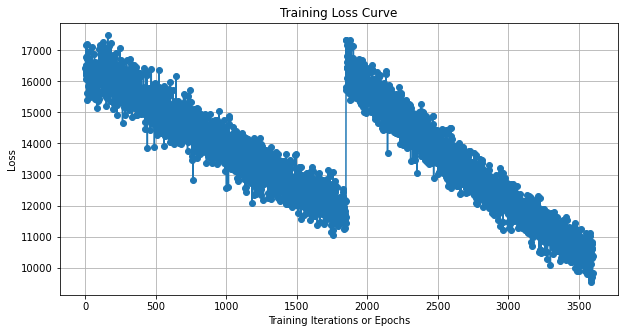

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(iterations, loss_errors, marker='o', linestyle='-')
plt.title('Training Loss Curve')
plt.xlabel('Training Iterations or Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Testing

In [79]:
model = WaveForecastingRNN(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

WaveForecastingRNN(
  (rnn): LSTM(228, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=228, bias=True)
)

In [80]:
datasettrain, dataloadertrain = buildTensor(data_test)

In [92]:
test_loss = 0.0
for inputs, targets in dataloadertrain:
    # Forward pass
    outputs = model(inputs)
    print("outputs: ", outputs, "\n", "targets: ", targets, "\n")
    
    # Compute loss
    loss = criterion(outputs, targets)
    print("loss:  ", loss)
    test_loss += loss.item()  # Accumulate the test loss

# Calculate and print average test loss
avg_test_loss = test_loss / len(dataloadertrain)
print(f'Average Test Loss: {avg_test_loss:.4f}')

outputs:  tensor([[ 6.2123, 52.7386,  2.1671,  ...,  6.7805, 51.9233,  0.9441],
        [ 6.1875, 52.5710,  2.1525,  ...,  6.7545, 51.7637,  0.9342],
        [ 6.2123, 52.7386,  2.1671,  ...,  6.7805, 51.9233,  0.9441],
        ...,
        [ 6.1874, 52.5707,  2.1524,  ...,  6.7544, 51.7634,  0.9342],
        [ 6.1875, 52.5710,  2.1525,  ...,  6.7545, 51.7637,  0.9342],
        [ 6.2124, 52.7387,  2.1671,  ...,  6.7805, 51.9234,  0.9441]],
       grad_fn=<AddmmBackward0>) 
 targets:  tensor([[  6.0000,  79.0000,   2.1000,  ...,   6.2500, 202.0000,   1.0000],
        [  6.7000, 196.5000,   0.9000,  ...,   6.8500, 169.0000,   0.8000],
        [  9.3500, 110.5000,   3.6500,  ...,   6.7000, 191.0000,   1.1500],
        ...,
        [  6.8500, 242.0000,   1.3000,  ...,   8.1500, 182.0000,   0.8500],
        [  5.9500, 248.5000,   1.4000,  ...,   7.4000, 176.5000,   0.9000],
        [  4.7500, 212.0000,   1.1000,  ...,   7.5000, 194.5000,   1.1500]]) 

loss:   tensor(9903.7324, grad_fn=<MseL